In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# ========================================
# CONFIGURATION: Select target for PCA
# ========================================

# Available targets:
# - "yield_strength_MPa"
# - "uts_MPa"
# - "elongation_pct"
# - "reduction_area_pct"
# - "charpy_temp_C"
# - "charpy_toughness_J"

TARGET_NAME = "yield_strength_MPa"  # <-- CHANGE THIS
VARIANCE_THRESHOLD = 0.90  # Retain components explaining 90% variance

print("=" * 70)
print(f"PCA ANALYSIS FOR TARGET: {TARGET_NAME}")
print("=" * 70)
print(f"Variance threshold: {VARIANCE_THRESHOLD*100:.0f}%")

# Define data directory
SPLITS_DIR = Path("../../data/data_splits")
target_dir = SPLITS_DIR / TARGET_NAME

# Check if directory exists
if not target_dir.exists():
    raise FileNotFoundError(f"Target directory not found: {target_dir}")

print(f"\n Data directory: {target_dir}")

PCA ANALYSIS FOR TARGET: yield_strength_MPa
Variance threshold: 90%

 Data directory: ..\..\data\data_splits\yield_strength_MPa


In [3]:
# Load data
print("\n[1/5] Loading data...")
X_train = pd.read_csv(target_dir / "X_train_clean.csv")
X_val   = pd.read_csv(target_dir / "X_val_clean.csv")
X_test  = pd.read_csv(target_dir / "X_test_clean.csv")

print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape:   {X_val.shape}")
print(f"  X_test shape:  {X_test.shape}")
print(f"  Features: {X_train.shape[1]}")

# Check for missing values
missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()

if missing_train + missing_val + missing_test > 0:
 print(f'
  [!] Warning: Missing values detected!')
    print(f"     Train: {missing_train}, Val: {missing_val}, Test: {missing_test}")
else:
    print(f"  --> No missing values detected")


[1/5] Loading data...
  X_train shape: (1340, 35)
  X_val shape:   (156, 35)
  X_test shape:  (156, 35)
  Features: 35
  --> No missing values detected


<>:18: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Ouissal\AppData\Local\Temp\ipykernel_37344\2811363326.py:18: SyntaxWarning: invalid escape sequence '\ '
 print(f'
  [!] Warning: Missing values detected!')


In [4]:
# Scale features (PCA is sensitive to feature scale)
print("\n[2/5] Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(f"  ✓ Features scaled using StandardScaler")
print(f"  ✓ Fitted on training data only (no data leakage)")


[2/5] Scaling features...
  ✓ Features scaled using StandardScaler
  ✓ Fitted on training data only (no data leakage)


In [6]:
# Fit PCA with all components for variance analysis
print("\n[3/5] Fitting PCA...")
pca = PCA(n_components=X_train.shape[1])
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"  --> PCA fitted with {X_train.shape[1]} components")
print(f"  --> Transformed all datasets")


[3/5] Fitting PCA...
  --> PCA fitted with 35 components
  --> Transformed all datasets



[4/5] Analyzing explained variance...
  --> Components for 90% variance: 19/35
  --> Actual variance retained: 91.45%
  --> Dimensionality reduction: 35 → 19 (54.3%)


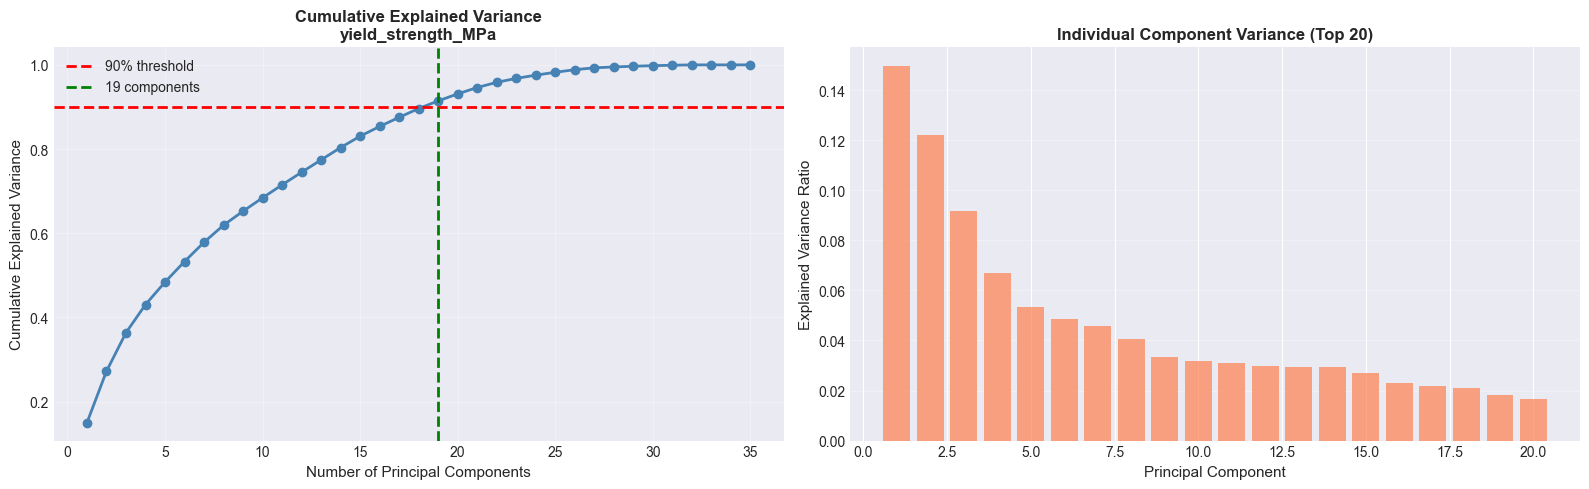


  Top 10 components by explained variance:
    PC1: 14.98% (cumulative: 14.98%)
    PC2: 12.23% (cumulative: 27.21%)
    PC3: 9.16% (cumulative: 36.37%)
    PC4: 6.68% (cumulative: 43.05%)
    PC5: 5.35% (cumulative: 48.40%)
    PC6: 4.87% (cumulative: 53.27%)
    PC7: 4.59% (cumulative: 57.86%)
    PC8: 4.05% (cumulative: 61.91%)
    PC9: 3.33% (cumulative: 65.24%)
    PC10: 3.17% (cumulative: 68.41%)


In [8]:
# Analyze explained variance
print("\n[4/5] Analyzing explained variance...")
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for threshold
n_components_threshold = np.argmax(cumulative_variance >= VARIANCE_THRESHOLD) + 1

print(f"  --> Components for {VARIANCE_THRESHOLD*100:.0f}% variance: {n_components_threshold}/{X_train.shape[1]}")
print(f"  --> Actual variance retained: {cumulative_variance[n_components_threshold-1]*100:.2f}%")
print(f"  --> Dimensionality reduction: {X_train.shape[1]} → {n_components_threshold} ({n_components_threshold/X_train.shape[1]*100:.1f}%)")

# Plot cumulative explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative variance
axes[0].plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', color='steelblue', linewidth=2)
axes[0].axhline(y=VARIANCE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'{VARIANCE_THRESHOLD*100:.0f}% threshold')
axes[0].axvline(x=n_components_threshold, color='green', linestyle='--', linewidth=2, label=f'{n_components_threshold} components')
axes[0].set_xlabel("Number of Principal Components", fontsize=11)
axes[0].set_ylabel("Cumulative Explained Variance", fontsize=11)
axes[0].set_title(f"Cumulative Explained Variance\n{TARGET_NAME}", fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Individual variance per component
axes[1].bar(range(1, min(21, len(explained_variance)+1)), explained_variance[:20], color='coral', alpha=0.7)
axes[1].set_xlabel("Principal Component", fontsize=11)
axes[1].set_ylabel("Explained Variance Ratio", fontsize=11)
axes[1].set_title("Individual Component Variance (Top 20)", fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print top components
print(f"\n  Top 10 components by explained variance:")
for i in range(min(10, len(explained_variance))):
    print(f"    PC{i+1}: {explained_variance[i]*100:.2f}% (cumulative: {cumulative_variance[i]*100:.2f}%)")

In [9]:
# Reduce to optimal number of components
print("\n[5/5] Applying dimensionality reduction...")
pca_reduced = PCA(n_components=n_components_threshold)
X_train_pca_reduced = pca_reduced.fit_transform(X_train_scaled)
X_val_pca_reduced   = pca_reduced.transform(X_val_scaled)
X_test_pca_reduced  = pca_reduced.transform(X_test_scaled)

print(f"  --> Reduced training shape:   {X_train_pca_reduced.shape}")
print(f"  --> Reduced validation shape: {X_val_pca_reduced.shape}")
print(f"  --> Reduced test shape:       {X_test_pca_reduced.shape}")
print(f"  --> Variance explained:       {pca_reduced.explained_variance_ratio_.sum()*100:.2f}%")


[5/5] Applying dimensionality reduction...
  --> Reduced training shape:   (1340, 19)
  --> Reduced validation shape: (156, 19)
  --> Reduced test shape:       (156, 19)
  --> Variance explained:       91.45%



PCA VISUALIZATIONS


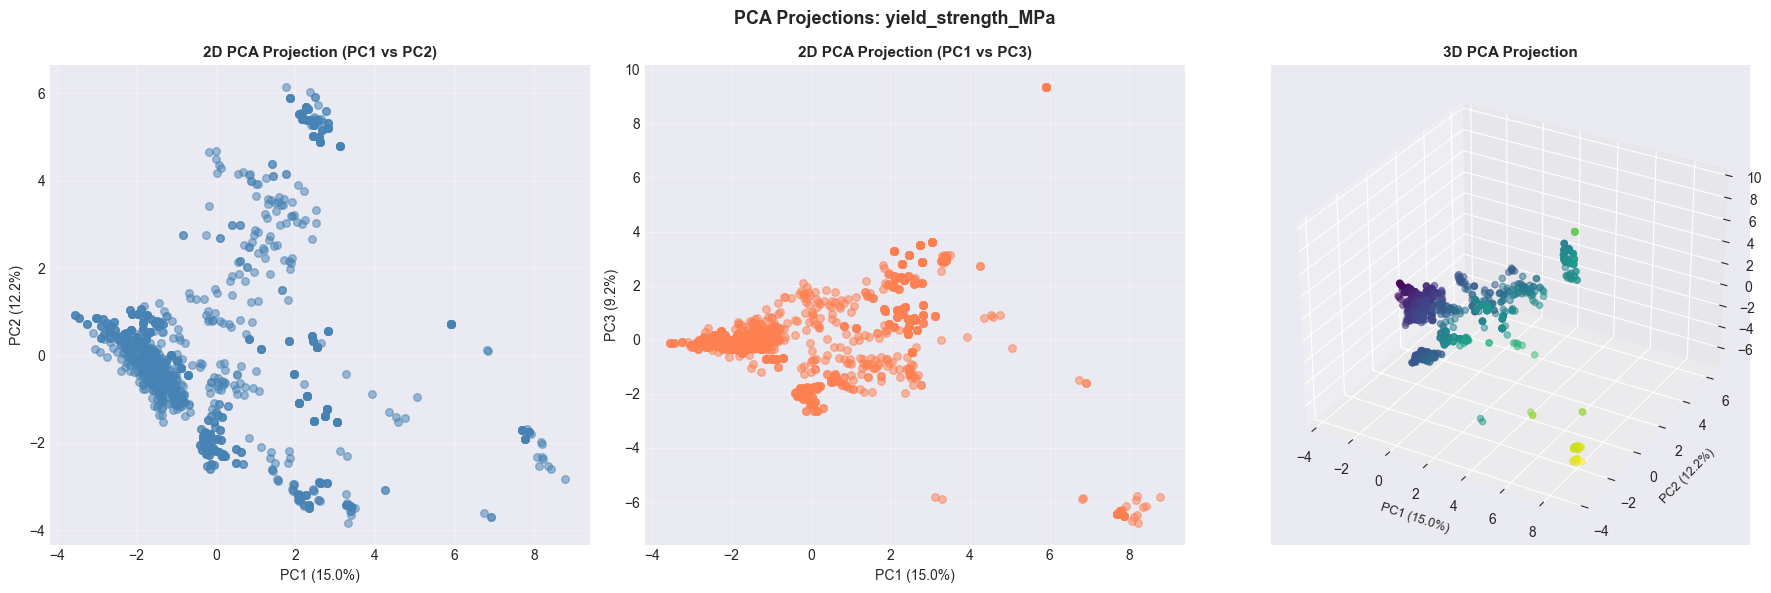

In [10]:
# 2D and 3D PCA Visualizations
print("\n" + "=" * 70)
print("PCA VISUALIZATIONS")
print("=" * 70)

fig = plt.figure(figsize=(18, 6))

# 2D projection (PC1 vs PC2)
ax1 = fig.add_subplot(131)
ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5, s=30, color='steelblue')
ax1.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)", fontsize=10)
ax1.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)", fontsize=10)
ax1.set_title("2D PCA Projection (PC1 vs PC2)", fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2D projection (PC1 vs PC3)
ax2 = fig.add_subplot(132)
ax2.scatter(X_train_pca[:, 0], X_train_pca[:, 2], alpha=0.5, s=30, color='coral')
ax2.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)", fontsize=10)
ax2.set_ylabel(f"PC3 ({explained_variance[2]*100:.1f}%)", fontsize=10)
ax2.set_title("2D PCA Projection (PC1 vs PC3)", fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3D projection
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], 
           alpha=0.5, s=20, c=X_train_pca[:, 0], cmap='viridis')
ax3.set_xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)", fontsize=9)
ax3.set_ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)", fontsize=9)
ax3.set_zlabel(f"PC3 ({explained_variance[2]*100:.1f}%)", fontsize=9)
ax3.set_title("3D PCA Projection", fontsize=11, fontweight='bold')

plt.suptitle(f"PCA Projections: {TARGET_NAME}", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# Save PCA-reduced datasets
print("\n" + "=" * 70)
print("SAVING PCA-REDUCED DATASETS")
print("=" * 70)

# Create column names for PCA features
pca_columns = [f'PC{i+1}' for i in range(n_components_threshold)]

# Convert to DataFrames (use the reduced versions)
X_train_pca_df = pd.DataFrame(X_train_pca_reduced, columns=pca_columns)
X_val_pca_df = pd.DataFrame(X_val_pca_reduced, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca_reduced, columns=pca_columns)

# Save to target-specific directory
X_train_pca_df.to_csv(target_dir / 'X_train_pca.csv', index=False)
X_val_pca_df.to_csv(target_dir / 'X_val_pca.csv', index=False)
X_test_pca_df.to_csv(target_dir / 'X_test_pca.csv', index=False)

print(f"\n==> PCA-reduced datasets saved to: {target_dir}/")
print(f"   - X_train_pca.csv: {X_train_pca_df.shape}")
print(f"   - X_val_pca.csv:   {X_val_pca_df.shape}")
print(f"   - X_test_pca.csv:  {X_test_pca_df.shape}")
print(f"\n==> Dimensionality reduction: {X_train.shape[1]} → {n_components_threshold} features")
print(f"==> Variance retained: {pca_reduced.explained_variance_ratio_.sum()*100:.2f}%")
print("\n" + "=" * 70)


SAVING PCA-REDUCED DATASETS

==> PCA-reduced datasets saved to: ..\..\data\data_splits\yield_strength_MPa/
   - X_train_pca.csv: (1340, 19)
   - X_val_pca.csv:   (156, 19)
   - X_test_pca.csv:  (156, 19)

==> Dimensionality reduction: 35 → 19 features
==> Variance retained: 91.45%

